## Sampling plans in the Familiar setting
This notebook steps through the *Familiar* setting of the case study of [*paper here*].
The goal is to illustrate how post-market surveillance (PMS) data, regulator priors on substandard and falsified product
(SFP) rates in a supply chain, and an encoding of regulatory objectives can be integrated towards designating sampling
plans.
See [*paper*] for more details.

This notebook uses the `logistigate` software package to conduct analysis; first import this package:

In [1]:
# CLEAN UP LATER: EVERYTHING SHOULD BE IN LOGISTIGATE
from logistigate.logistigate import utilities as util # Pull from the submodule "develop" branch
from logistigate.logistigate import methods
from logistigate.logistigate.priors import prior_normal_assort
from logistigate.logistigate import lossfunctions as lf
from logistigate.logistigate import samplingplanfunctions as sampf

import os
import numpy as np
from numpy.random import choice
import scipy.special as sps
import scipy.stats as spstat
import scipy.optimize as spo
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
import pickle
import time
import math
from math import comb
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
import drs

We then build a `logistigate` data dictionary containing prior data for 4 test nodes (provinces) and 13 supply nodes
(manufacturers). `Nfam` is a matrix of tests along each test node-supply node trace, and `Yfam' is a matrix of testing
positives along these traces.

In [2]:
Nfam = np.array([[1., 1., 10., 1., 3., 0., 1., 6., 7., 5., 0., 0., 4.],
                      [1., 1., 4., 2., 0., 1., 1., 2., 0., 4., 0., 0., 1.],
                      [3., 17., 31., 4., 2., 0., 1., 6., 0., 23., 1., 2., 5.],
                      [1., 1., 15., 2., 0., 0., 0., 1., 0., 6., 0., 0., 0.]])
Yfam = np.array([[0., 0., 7., 0., 3., 0., 1., 0., 1., 0., 0., 0., 4.],
                      [0., 0., 2., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
                      [0., 0., 15., 3., 2., 0., 0., 2., 0., 1., 1., 2., 5.],
                      [0., 0., 5., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
(numTN, numSN) = Nfam.shape # For later use
csdict_fam = util.initDataDict(Nfam, Yfam) # Initialize necessary logistigate keys
csdict_fam['TNnames'] = ['MOD_39', 'MOD_17', 'MODHIGH_95', 'MODHIGH_26']
csdict_fam['SNnames'] = ['MNFR ' + str(i+1) for i in range(numSN)]
# Region catchment proportions, for market terms
TNcach = np.array([0.17646, 0.05752, 0.09275, 0.09488])
TNcach = TNcach[:4] / np.sum(TNcach[:4])
SNcach = np.matmul(TNcach, csdict_fam['Q'])

# Some summaries
TNtesttotals = np.sum(Nfam, axis=1)
TNsfptotals = np.sum(Yfam, axis=1)
TNrates = np.divide(TNsfptotals,TNtesttotals)
print('Tests at each test node:')
print(TNtesttotals)
print('Positives at each test node:')
print(TNsfptotals)
print('Positive rates at each test node:')
print(TNrates)

Tests at each test node:
[39. 17. 95. 26.]
Positives at each test node:
[16.  8. 31.  7.]
Positive rates at each test node:
[0.41025641 0.47058824 0.32631579 0.26923077]


We then need to incorporate a prior on SFP rates at each node in the supply chain, so a set of initial MCMC draws can
be generated:

Generating posterior samples...
Posterior samples generated


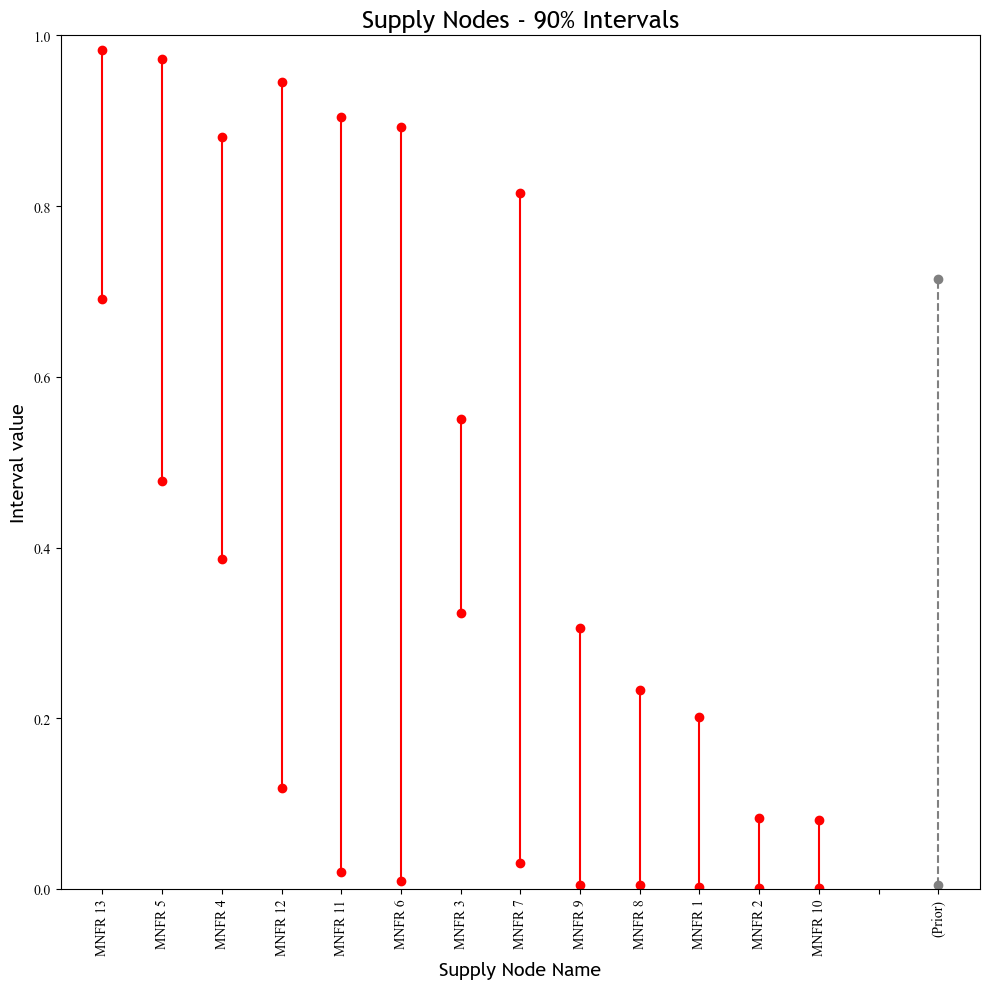

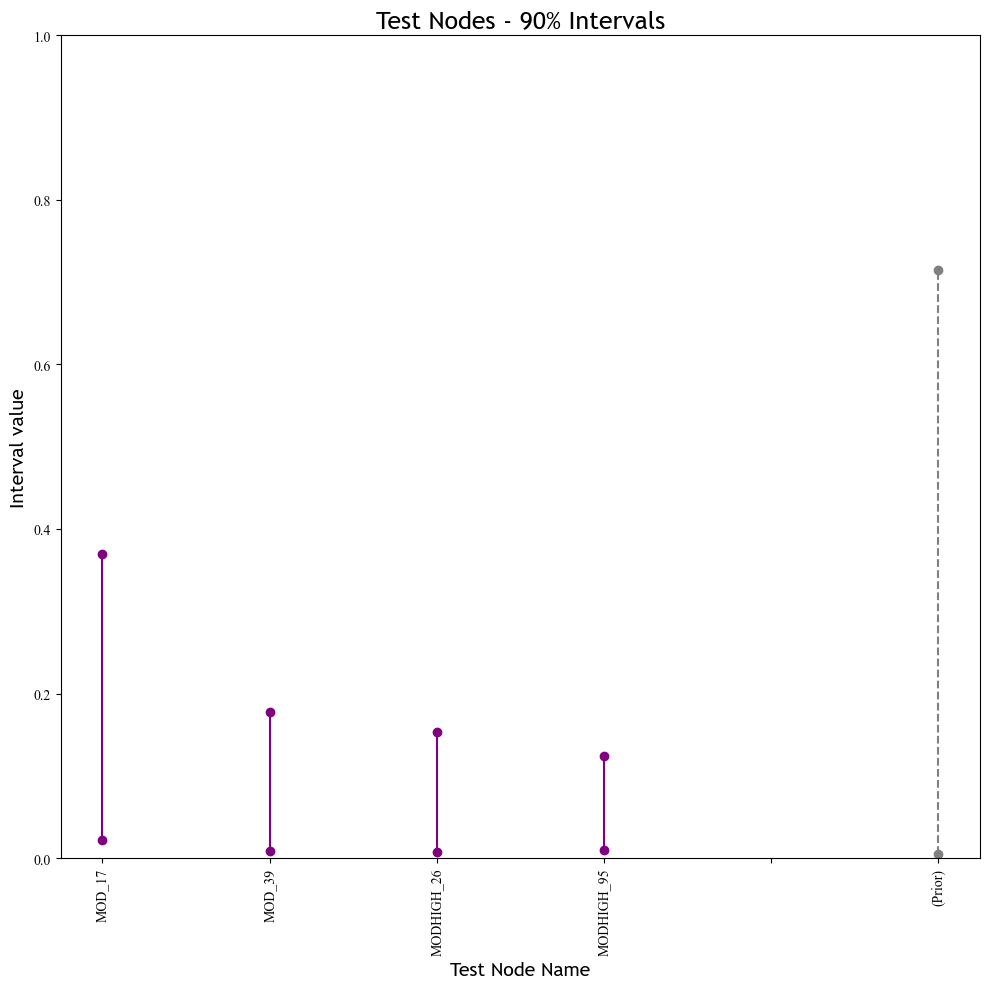

In [3]:
# Build prior
SNpriorMean = np.repeat(sps.logit(0.1), numSN)
# Establish test node priors according to assessment by regulators
TNpriorMean = sps.logit(np.array([0.1, 0.1, 0.15, 0.15]))
priorMean = np.concatenate((SNpriorMean, TNpriorMean))
TNvar, SNvar = 2., 4.  # Variances for use with prior; supply nodes are wide due to large
priorCovar = np.diag(np.concatenate((np.repeat(SNvar, numSN), np.repeat(TNvar, numTN))))
priorObj = prior_normal_assort(priorMean, priorCovar)
csdict_fam['prior'] = priorObj

# Set up MCMC
csdict_fam['MCMCdict'] = {'MCMCtype': 'NUTS', 'Madapt': 5000, 'delta': 0.4}
# Generate posterior draws
numdraws = 80000
csdict_fam['numPostSamples'] = numdraws
np.random.seed(1000) # To replicate draws later
csdict_fam = methods.GeneratePostSamples(csdict_fam)
# Print inference from initial data
util.plotPostSamples(csdict_fam, 'int90')

Sampling plan evaluation requires specification of the loss as well as estimation parameters:

In [8]:
# Loss specification
paramdict = lf.build_diffscore_checkrisk_dict(scoreunderestwt=5., riskthreshold=0.15, riskslope=0.6,
                                                  marketvec=np.ones(numTN + numSN), candneighnum=1000)

# Set limits of data collection and intervals for calculation
testmax, testint = 400, 10
testarr = np.arange(testint, testmax + testint, testint)

Next set algorithm parameters, including the draws to use as candidate draws, truth draws, and data draws.
Plan utility is calcualted at each test node for each testing interval; performing 10 replications reduces estimate
variance.

In [ ]:
# Set MCMC draws to use in fast algorithm
numcanddraws, numtruthdraws, numdatadraws = 5000, 5000, 3000
numReps = 10 # Number of repeat runs to make
# Divide original draws into numReps sets to use with utility estimation
np.random.seed(10)
shufinds = np.arange(numdraws)
np.random.shuffle(shufinds)
indsList = [shufinds[i*numcanddraws:(i+1)*numcanddraws] for i in range(numReps)]

utilMatList = [] # Initialize results list
for rep in range(numReps):
    # Pull relevant draws
    currcanddraws = csdict_fam['postSamples'][indsList[rep]]
    currtruthdraws = currcanddraws[choice(np.arange(numcanddraws), size=numtruthdraws, replace=False)]
    currdatadraws = currtruthdraws[choice(np.arange(numtruthdraws), size=numdatadraws, replace=False)]
    # Update paramdict
    paramdict.update({'canddraws':currcanddraws, 'truthdraws':currtruthdraws, 'datadraws':currdatadraws})
    # Build loss matrix
    lossmatrix = lf.build_loss_matrix(currtruthdraws, currcanddraws, paramdict)
    baseloss = sampf.baseloss(lossmatrix)
    paramdict.update({'lossmatrix': lossmatrix})
    # Checks
    print('Candidate draws: ' + str(paramdict['lossmatrix'].shape[0]))
    print('Truth draws: ' + str(paramdict['lossmatrix'].shape[1]))
    print('Data draws: ' + str(paramdict['datadraws'].shape[0]))
    print('Baseline loss: ' + str(baseloss))
    # Iterate through each test node and sampling budget and obtain utility
    currMargUtilMat = np.zeros((numTN, testarr.shape[0] + 1))
    for tnInd in range(numTN):
        currDes = np.zeros(numTN)
        currDes[tnInd] = 1.
        print('Utility for TN ' + str(tnInd) + '...')
        print('Design: ' + str(currDes.round(2)))
        for testInd in range(testarr.shape[0]):
            currUtil = baseloss - sampf.sampling_plan_loss_fast(design=currDes, numtests=testarr[testInd],
                                                     priordatadict=csdict_fam, paramdict=paramdict)
            print('Utility for budget ' + str(testarr[testInd]) + ': ' + str(currUtil))
            currMargUtilMat[tnInd, testInd + 1] = currUtil

    print('Utility matrix for replication ' + str(rep) + ':')
    print(repr(currMargUtilMat))
    utilMatList.append(currMargUtilMat)
# Plot
colors = cm.rainbow(np.linspace(0, 1., numTN))
for mat in utilMatList:
    for i in range(numTN):
        plt.plot(testarr, mat[i][1:], linewidth=0.2, color=colors[i])
avgUtilMat = np.average(np.array(utilMatList), axis=0)
for i in range(numTN):
    plt.plot(testarr, avgUtilMat[i][1:], linewidth=2, color=colors[i])
# plt.ylim([0, 0.4])
# plt.title('Comprehensive utility for allocations via heuristic\nUntested nodes')
plt.show()
plt.close()

In [ ]:
# OPTIONAL save the list of utility estimate matrices
np.save(os.path.join('casestudyoutputs', '16MAY', 'utilmatlist_familiar'), np.array(utilMatList))

In [7]:
# OPTIONAL load the list of utility estimate matrices
utilMatList = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'FAMILIA', 'utilmatlist_familiar.npy'))

The average across replications is used to build allocations for the considered budgetary range:

In [5]:
# Retrieve allocation
avgUtilMat = np.average(np.array(utilMatList), axis=0)
# Plot
util.plot_marg_util(avgUtilMat, testmax, testint, labels=csdict_fam['TNnames'], type='delta',
             titleStr='Familiar Setting, $t=0.15$, $m=0.6$', lineLabels=True, utilMax=0.1,
             colors=cm.rainbow(np.linspace(0, 0.5, numTN)), dashes=[[1, 0] for tn in range(numTN)])
allocArr, objValArr = sampf.smooth_alloc_forward(avgUtilMat)
util.plot_plan(allocArr, paramList=[str(i) for i in np.arange(testint, testmax + 1, testint)], testInt=testint,
          labels=csdict_fam['TNnames'], titleStr='Familiar Setting, $t=0.15$, $m=0.6$', allocMax=250,
          colors=cm.rainbow(np.linspace(0, 0.5, numTN)), dashes=[[1, 0] for tn in range(numTN)])

In [8]:
# Now get comprehensive utilities for different sampling plans; use different set of MCMC draws
np.random.seed(11)
csdict_fam = methods.GeneratePostSamples(csdict_fam)
np.random.seed(12)
shufinds = np.arange(numdraws)
np.random.shuffle(shufinds)
indsList = [shufinds[i * numcanddraws:(i + 1) * numcanddraws] for i in range(numReps)]

heur_utillist, unif_utillist, rudi_utillist = [], [], [] #  Initialize storage lists
numReps = 10
for rep in range(numReps):
    # Pull relevant draws
    currcanddraws = csdict_fam['postSamples'][indsList[rep]]
    currtruthdraws = currcanddraws[choice(np.arange(numcanddraws), size=numtruthdraws, replace=False)]
    currdatadraws = currtruthdraws[choice(np.arange(numtruthdraws), size=numdatadraws, replace=False)]
    # Update paramdict
    paramdict.update({'canddraws': currcanddraws, 'truthdraws': currtruthdraws, 'datadraws': currdatadraws})
    # Build loss matrix
    lossmatrix = lf.build_loss_matrix(currtruthdraws, currcanddraws, paramdict)
    baseloss = sampf.baseloss(lossmatrix)
    paramdict.update({'lossmatrix': lossmatrix})
    # Checks
    print('Candidate draws: ' + str(paramdict['lossmatrix'].shape[0]))
    print('Truth draws: ' + str(paramdict['lossmatrix'].shape[1]))
    print('Data draws: ' + str(paramdict['datadraws'].shape[0]))
    print('Baseline loss: ' + str(baseloss))
    # Iterate through each design and sampling budget and obtain utility
    curr_heur_utillist, curr_unif_utillist, curr_rudi_utillist = [], [], []
    for testInd in range(testarr.shape[0]):
        # Heuristic design
        heur_des = allocArr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=heur_des, numtests=testarr[testInd],
                                                                priordatadict=csdict_fam, paramdict=paramdict)
        curr_heur_utillist.append(currUtil)
        # Uniform design
        unif_des = util.round_design_low(np.ones(numTN) / numTN, testarr[testInd]) / testarr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=unif_des, numtests=testarr[testInd],
                                                            priordatadict=csdict_fam, paramdict=paramdict)
        curr_unif_utillist.append(currUtil)
        # Rudimentary design
        rudi_des = util.round_design_low(np.divide(np.sum(Nfam, axis=1), np.sum(Nfam)), testarr[testInd]) / testarr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=rudi_des, numtests=testarr[testInd],
                                                            priordatadict=csdict_fam, paramdict=paramdict)
        curr_rudi_utillist.append(currUtil)
    print('Utility matrices for replication ' + str(rep) + ':')
    print(curr_heur_utillist)
    print(curr_unif_utillist)
    print(curr_rudi_utillist)
    heur_utillist.append(curr_heur_utillist)
    unif_utillist.append(curr_unif_utillist)
    rudi_utillist.append(curr_rudi_utillist)

In [ ]:
# OPTIONAL
# np.save(os.path.join('casestudyoutputs', '16MAY', 'heur_utillist_familiar'), np.array(heur_utillist))
# np.save(os.path.join('casestudyoutputs', '16MAY', 'unif_utillist_familiar'), np.array(unif_utillist))
# np.save(os.path.join('casestudyoutputs', '16MAY', 'rudi_utillist_familiar'), np.array(rudi_utillist))

In [11]:
heur_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'Familiar', 'heur_utillist_familiar.npy'))
unif_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'unif_utillist_familiar.npy'))
rudi_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'rudi_utillist_familiar.npy'))

